# SMS Spam Detection - Final Project
**Authors:** Moheb Abdelmasih & Niveditha Renganathan

## Project Overview
This project implements binary text classification to identify whether an SMS message is legitimate (ham) or spam.

**Dataset:** [SMS Spam Collection Dataset](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)

**Models Implemented:**
- Naive Bayes Classifier
- Logistic Regression
- Support Vector Machine (SVM)
- Convolutional Neural Network (CNN)

**Evaluation Metrics:**
- Accuracy
- F1 Score

## 1. Import Libraries and Load Dataset

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string

# NLP and preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Load the dataset
# The dataset is tab-separated with no header
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

print(f"Dataset loaded successfully!")
print(f"Total number of messages: {len(df)}")
print(f"\nFirst few rows:")
df.head(10)

Dataset loaded successfully!
Total number of messages: 5572

First few rows:


,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To c...
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with came...


## 2. Exploratory Data Analysis (EDA)

In [5]:
# Basic dataset information
print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Class distribution
print("\n" + "="*50)
print("Class Distribution:")
print("="*50)
print(df['label'].value_counts())
print(f"\nPercentage distribution:")
print(df['label'].value_counts(normalize=True) * 100)

Dataset Information:
Shape: (5572, 2)

Data types:
label      object
message    object
dtype: object

Missing values:
label      0
message    0
dtype: int64

Duplicate rows: 403

Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Percentage distribution:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


C:\Users\maran\AppData\Local\Temp\ipykernel_46952\3515921275.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', ax=axes[0], palette='Set2')


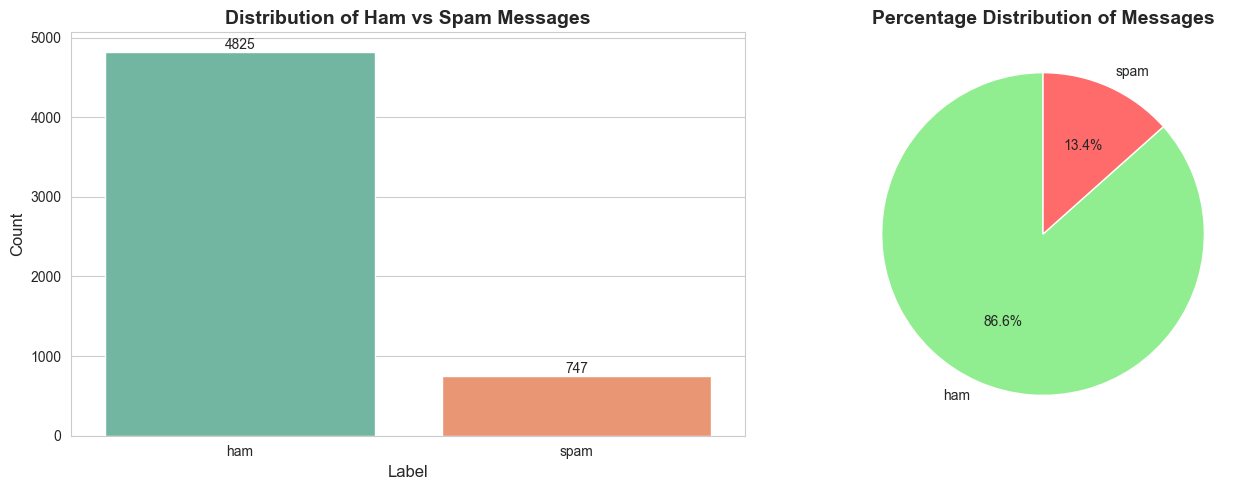

In [6]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='label', ax=axes[0], palette='Set2')
axes[0].set_title('Distribution of Ham vs Spam Messages', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
for container in axes[0].containers:
    axes[0].bar_label(container)

# Pie chart
colors = ['#90EE90', '#FF6B6B']
df['label'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                 colors=colors, startangle=90)
axes[1].set_title('Percentage Distribution of Messages', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [7]:
# Text length analysis
df['message_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

print("Message Length Statistics:")
print(df.groupby('label')[['message_length', 'word_count']].describe().round(2))

Message Length Statistics:
      message_length                                                    
               count    mean    std   min    25%    50%    75%    max   
label                                                                   
ham           4825.0   71.48  58.44   2.0   33.0   52.0   93.0  910.0  \
spam           747.0  138.67  28.87  13.0  133.0  149.0  157.0  223.0   

      word_count                                              
           count   mean    std  min   25%   50%   75%    max  
label                                                         
ham       4825.0  14.31  11.52  1.0   7.0  11.0  19.0  171.0  
spam       747.0  23.91   5.78  2.0  22.0  25.0  28.0   35.0  


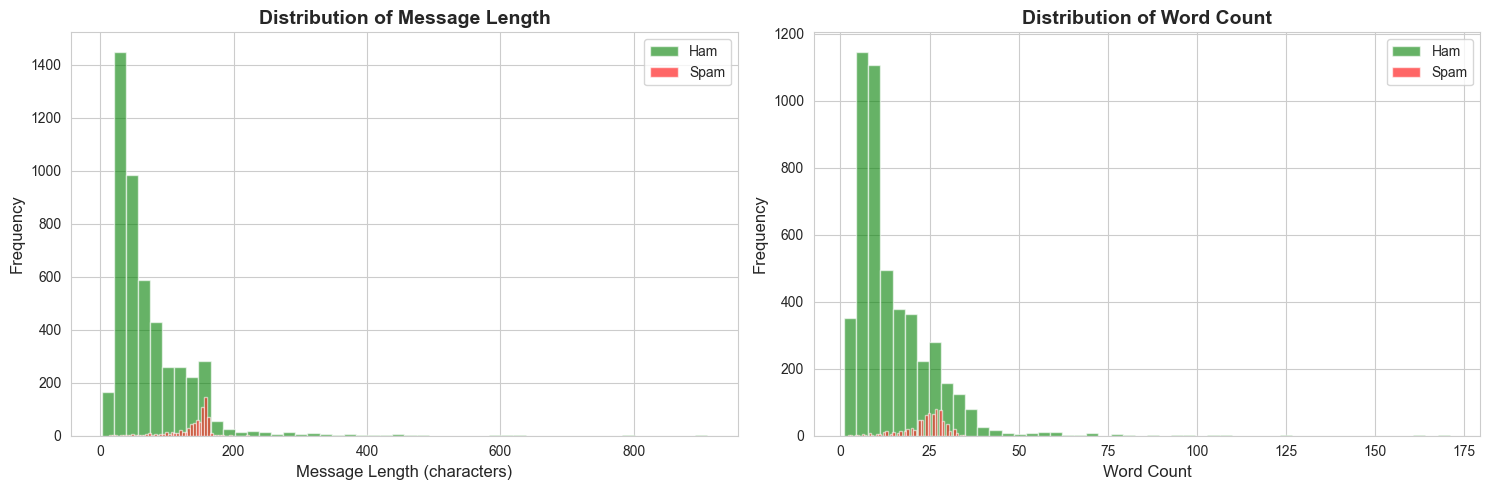

In [8]:
# Visualize message length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Message character length
df[df['label'] == 'ham']['message_length'].hist(bins=50, alpha=0.6, label='Ham', 
                                                  color='green', ax=axes[0])
df[df['label'] == 'spam']['message_length'].hist(bins=50, alpha=0.6, label='Spam', 
                                                   color='red', ax=axes[0])
axes[0].set_xlabel('Message Length (characters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Message Length', fontsize=14, fontweight='bold')
axes[0].legend()

# Word count
df[df['label'] == 'ham']['word_count'].hist(bins=50, alpha=0.6, label='Ham', 
                                             color='green', ax=axes[1])
df[df['label'] == 'spam']['word_count'].hist(bins=50, alpha=0.6, label='Spam', 
                                              color='red', ax=axes[1])
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Word Count', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Text Preprocessing Pipeline

We'll implement comprehensive text preprocessing including:
- Converting to lowercase
- Removing special characters and punctuation
- Removing numbers
- Tokenization
- Removing stopwords (common words like 'and', 'or', 'the', etc.)
- Stemming (reducing words to their root form)

In [9]:
# Initialize preprocessing tools
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    
    Args:
        text (str): Raw text message
    
    Returns:
        str: Preprocessed text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    # Join tokens back to string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Test the preprocessing function
print("Example of text preprocessing:")
print("="*80)
sample_message = df[df['label'] == 'spam']['message'].iloc[0]
print(f"Original: {sample_message}")
print(f"\nPreprocessed: {preprocess_text(sample_message)}")
print("="*80)

Example of text preprocessing:
Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Preprocessed: free entri wkli comp win cup final tkt may text receiv entri questionstd txt ratetc appli over


In [10]:
# Apply preprocessing to all messages
print("Preprocessing all messages...")
df['processed_message'] = df['message'].apply(preprocess_text)

# Show examples
print("\nExamples of preprocessed messages:")
print("="*80)
for i in range(3):
    print(f"\nOriginal: {df['message'].iloc[i]}")
    print(f"Processed: {df['processed_message'].iloc[i]}")
    print("-"*80)

Preprocessing all messages...

Examples of preprocessed messages:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: jurong point crazi avail bugi great world buffet cine got amor wat
--------------------------------------------------------------------------------

Original: Ok lar... Joking wif u oni...
Processed: lar joke wif oni
--------------------------------------------------------------------------------

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: free entri wkli comp win cup final tkt may text receiv entri questionstd txt ratetc appli over
--------------------------------------------------------------------------------


## 4. Feature Engineering with TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that evaluates how important a word is to a document in a collection of documents. It increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

In [11]:
# Prepare features (X) and labels (y)
X = df['processed_message']
y = df['label'].map({'ham': 0, 'spam': 1})  # Convert labels to binary

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=0, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Training set size: 4457
Testing set size: 1115

Training set class distribution:
label
0    3859
1     598
Name: count, dtype: int64

Testing set class distribution:
label
0    966
1    149
Name: count, dtype: int64


In [12]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3000, min_df=2, max_df=0.8)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Feature Matrix Shape:")
print(f"Training: {X_train_tfidf.shape}")
print(f"Testing: {X_test_tfidf.shape}")
print(f"\nNumber of features (vocabulary size): {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF Feature Matrix Shape:
Training: (4457, 2662)
Testing: (1115, 2662)

Number of features (vocabulary size): 2662


## 5. Model Training and Evaluation

We'll train and evaluate three different models:
1. **Naive Bayes** - Probabilistic classifier based on Bayes' theorem
2. **Logistic Regression** - Linear model for binary classification
3. **Support Vector Machine (SVM)** - Finds optimal hyperplane for classification
4. **MLP Model**
4. **CNN Model with Keras**

In [2]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a machine learning model
    
    Args:
        model: Sklearn classifier
        X_train, X_test: Training and testing features
        y_train, y_test: Training and testing labels
        model_name: Name of the model for display
    
    Returns:
        dict: Dictionary containing model performance metrics
    """
    print(f"\n{'='*80}")
    print(f"Training {model_name}...")
    print(f"{'='*80}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"-" * 80)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy:  {test_accuracy:.4f}")
    print(f"Precision:         {test_precision:.4f}")
    print(f"Recall:            {test_recall:.4f}")
    print(f"F1 Score:          {test_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['Ham', 'Spam']))
    
    # Store results
    results = {
        'model': model,
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'confusion_matrix': cm,
        'y_pred': y_pred_test
    }
    
    return results

### 5.1 Naive Bayes Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# Train Naive Bayes classifier
nb_model = MultinomialNB()

# alpha values to try
param_grid = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 100.0]
}

# to get variance, split data 25 times
cv_strategy = ShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

# Run Grid Search
grid_search = GridSearchCV(
    nb_model,
    param_grid,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit the grid search
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and score
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Testing model with default params
print("Naive Bayes with Default Params")
nb_default = MultinomialNB()  # Create new instance
nb_default.fit(X_train_tfidf, y_train) 
nb_results = evaluate_model(nb_model, X_train_tfidf, X_test_tfidf, 
                             y_train, y_test, "Naive Bayes")


# Testing model with the optimized params
print("Naive Bayes with Optimized Params")
best_nb_model = grid_search.best_estimator_
nb_results = evaluate_model(best_nb_model, X_train_tfidf, X_test_tfidf, 
                             y_train, y_test, "Naive Bayes")

Fitting 25 folds for each of 10 candidates, totalling 250 fits
Best alpha: 0.1
Best cross-validation score: 0.9243
Naive Bayes with Default Params

Training Naive Bayes...

Naive Bayes Performance:
--------------------------------------------------------------------------------
Training Accuracy: 0.9809
Testing Accuracy:  0.9668
Precision:         0.9828
Recall:            0.7651
F1 Score:          0.8604

Confusion Matrix:
[[964   2]
 [ 35 114]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.98      0.77      0.86       149

    accuracy                           0.97      1115
   macro avg       0.97      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

Naive Bayes with Optimized Params

Training Naive Bayes...

Naive Bayes Performance:
--------------------------------------------------------------------------------
Training Accuracy: 0.9899
Testin

C:\Users\maran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_resampling.py:144: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\maran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


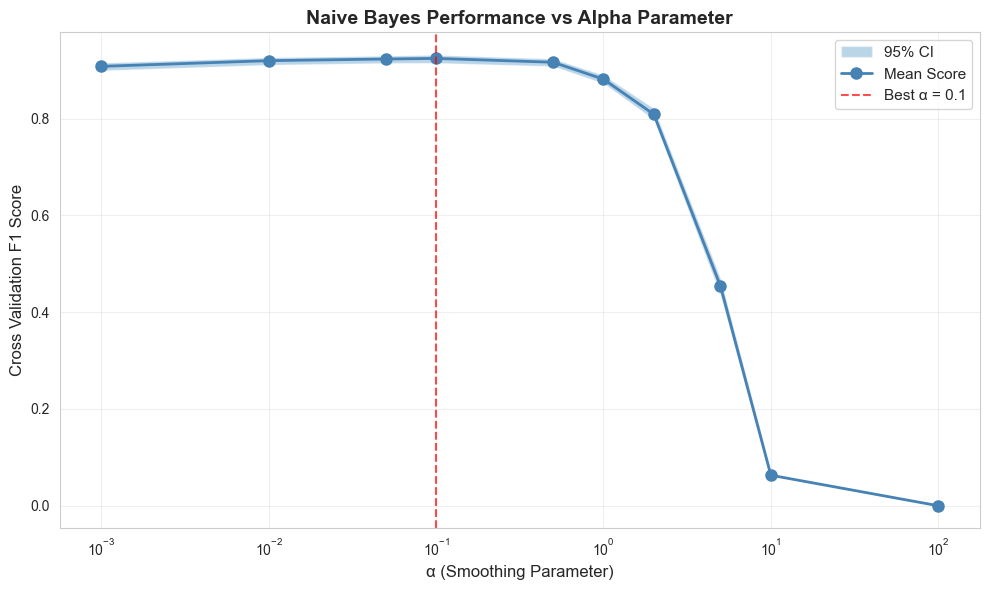

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# Extract results from grid search
results_df = pd.DataFrame(grid_search.cv_results_)

alphas = param_grid['alpha']
means = []
ci_lowers = []
ci_uppers = []
trials = grid_search.n_splits_

for alpha in alphas:
    # get scores for each fold
    fold_scores = []
    for i in range(trials):
        key = f'split{i}_test_score'
        index = list(results_df['param_alpha']).index(alpha)
        fold_scores.append(results_df[key].iloc[index])
    
    fold_scores = np.array(fold_scores)
    means.append(np.mean(fold_scores))
    
    # using bootstrap to calc 95%
    ci_low, ci_high = scipy.stats.bootstrap(
        [fold_scores], 
        np.mean,
        random_state=42
    ).confidence_interval
    
    ci_lowers.append(ci_low)
    ci_uppers.append(ci_high)

means = np.array(means)
ci_lowers = np.array(ci_lowers)
ci_uppers = np.array(ci_uppers)

# Plot
plt.figure(figsize=(10, 6))
plt.fill_between(alphas, ci_lowers, ci_uppers, alpha=0.3, label='95% CI')
plt.plot(alphas, means, marker='o', linestyle='-', linewidth=2, markersize=8, 
         color='steelblue', label='Mean Score')

# Mark the best alpha
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_
plt.axvline(x=best_alpha, color='r', linestyle='--', alpha=0.7, 
            label=f'Best α = {best_alpha}')
plt.xscale('log')
plt.xlabel('α (Smoothing Parameter)', fontsize=12)
plt.ylabel('Cross Validation F1 Score', fontsize=12)
plt.title('Naive Bayes Performance vs Alpha Parameter',fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

### 5.2 Logistic Regression

In [13]:
# Hyperparameter Tuning for Logistic Regression
print("="*80)
print("LOGISTIC REGRESSION HYPERPARAMETER TUNING")
print("="*80)

from sklearn.model_selection import GridSearchCV
import time

# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # Both support L1 and L2
}

# Create base model
lr_base = LogisticRegression(max_iter=1000, random_state=42)

# Perform grid search with 5-fold cross-validation
print("\nPerforming Grid Search with 5-fold Cross-Validation...")
print(f"Testing {len(param_grid_lr['C']) * len(param_grid_lr['penalty']) * len(param_grid_lr['solver'])} parameter combinations\n")

start_time = time.time()

grid_search_lr = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search_lr.fit(X_train_tfidf, y_train)

elapsed_time = time.time() - start_time

print(f"\nGrid Search Complete! Time taken: {elapsed_time:.2f} seconds")
print(f"\nBest Parameters: {grid_search_lr.best_params_}")
print(f"Best Cross-Validation F1 Score: {grid_search_lr.best_score_:.4f}")

LOGISTIC REGRESSION HYPERPARAMETER TUNING

Performing Grid Search with 5-fold Cross-Validation...
Testing 20 parameter combinations

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10


Grid Search Complete! Time taken: 9.91 seconds

Best Parameters: {'C': 100.0, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation F1 Score: 0.9347


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



LOGISTIC REGRESSION: TOP 10 PARAMETER COMBINATIONS
    C Penalty    Solver  Train F1    CV F1   Std F1  Rank
100.0      l2      saga  0.998325 0.934722 0.008652     1
100.0      l2 liblinear  0.998325 0.932868 0.008035     2
 10.0      l2      saga  0.987765 0.922252 0.007283     3
 10.0      l2 liblinear  0.987550 0.922252 0.007283     3
100.0      l1      saga  0.998325 0.920167 0.014701     5
100.0      l1 liblinear  0.998325 0.909411 0.009918     6
 10.0      l1 liblinear  0.997906 0.908637 0.011513     7
 10.0      l1      saga  0.997906 0.908498 0.011389     8
  1.0      l2      saga  0.866499 0.824404 0.020842     9
  1.0      l2 liblinear  0.866499 0.824404 0.020842     9


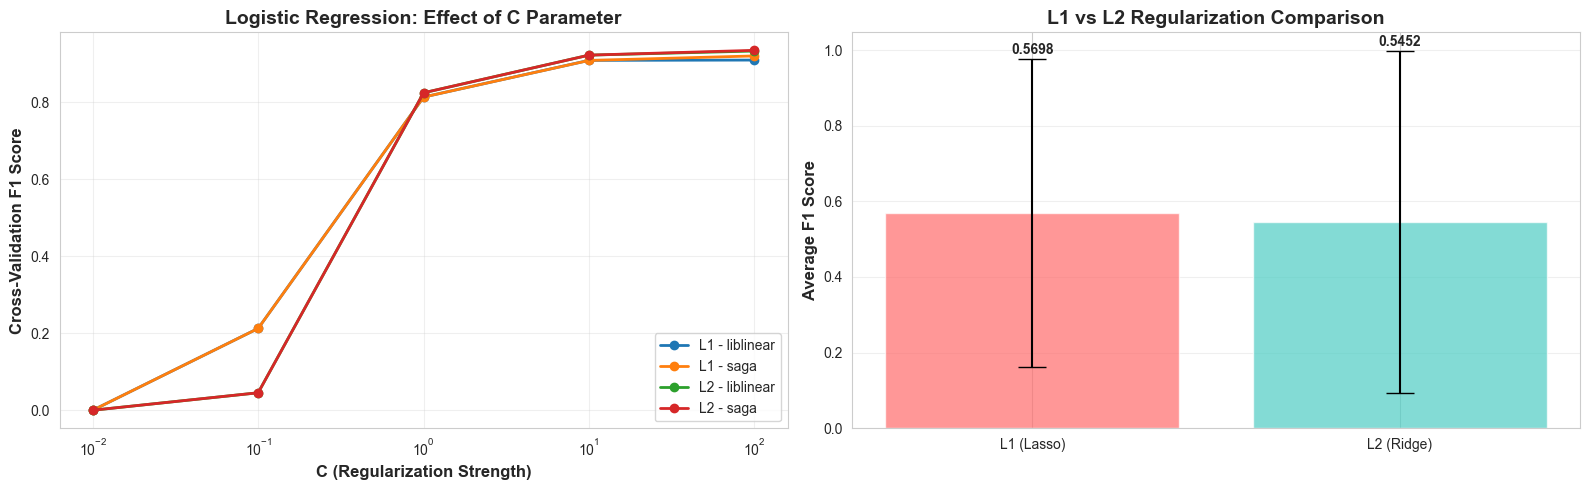


SOLVER COMPARISON
                  mean       std       max
param_solver                              
liblinear     0.556877  0.429561  0.932868
saga          0.558124  0.430721  0.934722


In [14]:
# Visualize Logistic Regression hyperparameter tuning results
import pandas as pd

# Extract results
cv_results_lr = pd.DataFrame(grid_search_lr.cv_results_)

# Create summary table
summary_lr = cv_results_lr[['param_C', 'param_penalty', 'param_solver', 
                             'mean_train_score', 'mean_test_score', 
                             'std_test_score', 'rank_test_score']].copy()
summary_lr.columns = ['C', 'Penalty', 'Solver', 'Train F1', 'CV F1', 'Std F1', 'Rank']
summary_lr = summary_lr.sort_values('Rank')

print("\n" + "="*100)
print("LOGISTIC REGRESSION: TOP 10 PARAMETER COMBINATIONS")
print("="*100)
print(summary_lr.head(10).to_string(index=False))
print("="*100)

# Visualize C parameter effect
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: C vs F1 Score for different penalties
for penalty in ['l1', 'l2']:
    for solver in ['liblinear', 'saga']:
        mask = (cv_results_lr['param_penalty'] == penalty) & (cv_results_lr['param_solver'] == solver)
        if mask.any():
            data = cv_results_lr[mask]
            axes[0].plot(data['param_C'], data['mean_test_score'], 
                        marker='o', label=f'{penalty.upper()} - {solver}', linewidth=2)

axes[0].set_xscale('log')
axes[0].set_xlabel('C (Regularization Strength)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cross-Validation F1 Score', fontsize=12, fontweight='bold')
axes[0].set_title('Logistic Regression: Effect of C Parameter', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Comparison of penalties
penalty_comparison = cv_results_lr.groupby('param_penalty')['mean_test_score'].agg(['mean', 'std'])
x_pos = np.arange(len(penalty_comparison))
axes[1].bar(x_pos, penalty_comparison['mean'], yerr=penalty_comparison['std'], 
           alpha=0.7, capsize=10, color=['#FF6B6B', '#4ECDC4'])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['L1 (Lasso)', 'L2 (Ridge)'])
axes[1].set_ylabel('Average F1 Score', fontsize=12, fontweight='bold')
axes[1].set_title('L1 vs L2 Regularization Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (mean_val, std_val) in enumerate(zip(penalty_comparison['mean'], penalty_comparison['std'])):
    axes[1].text(i, mean_val + std_val + 0.005, f'{mean_val:.4f}', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Solver comparison
print("\n" + "="*80)
print("SOLVER COMPARISON")
print("="*80)
solver_comparison = cv_results_lr.groupby('param_solver')['mean_test_score'].agg(['mean', 'std', 'max'])
print(solver_comparison)

In [15]:
# Train Logistic Regression classifier
lr_model = LogisticRegression(max_iter=1000, random_state=0)
lr_results = evaluate_model(lr_model, X_train_tfidf, X_test_tfidf, 
                             y_train, y_test, "Logistic Regression")


Training Logistic Regression...

Logistic Regression Performance:
--------------------------------------------------------------------------------
Training Accuracy: 0.9715
Testing Accuracy:  0.9543
Precision:         0.9712
Recall:            0.6779
F1 Score:          0.7984

Confusion Matrix:
[[963   3]
 [ 48 101]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.97       966
        Spam       0.97      0.68      0.80       149

    accuracy                           0.95      1115
   macro avg       0.96      0.84      0.89      1115
weighted avg       0.96      0.95      0.95      1115



/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


In [16]:
# Train Logistic Regression with BEST parameters from grid search
print("\n" + "="*80)
print("TRAINING LOGISTIC REGRESSION WITH OPTIMAL PARAMETERS")
print("="*80)

lr_model = LogisticRegression(
    C=grid_search_lr.best_params_['C'],
    penalty=grid_search_lr.best_params_['penalty'],
    solver=grid_search_lr.best_params_['solver'],
    max_iter=1000,
    random_state=42
)

lr_results = evaluate_model(lr_model, X_train_tfidf, X_test_tfidf, 
                             y_train, y_test, "Logistic Regression (Optimized)")

# Compare with default parameters
print("\n" + "="*80)
print("COMPARISON: OPTIMIZED vs DEFAULT PARAMETERS")
print("="*80)

lr_default = LogisticRegression(max_iter=1000, random_state=42)
lr_default.fit(X_train_tfidf, y_train)
y_pred_default = lr_default.predict(X_test_tfidf)

default_f1 = f1_score(y_test, y_pred_default)
optimized_f1 = lr_results['f1_score']

print(f"Default Parameters (C=1.0, L2, lbfgs):  F1 = {default_f1:.4f}")
print(f"Optimized Parameters:                     F1 = {optimized_f1:.4f}")
print(f"Improvement:                              +{(optimized_f1 - default_f1):.4f} ({((optimized_f1/default_f1 - 1)*100):.2f}%)")


TRAINING LOGISTIC REGRESSION WITH OPTIMAL PARAMETERS

Training Logistic Regression (Optimized)...

Logistic Regression (Optimized) Performance:
--------------------------------------------------------------------------------
Training Accuracy: 0.9996
Testing Accuracy:  0.9758
Precision:         0.9552
Recall:            0.8591
F1 Score:          0.9046

Confusion Matrix:
[[960   6]
 [ 21 128]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       966
        Spam       0.96      0.86      0.90       149

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


COMPARISON: OPTIMIZED vs DEFAULT PARAMETERS
Default Parameters (C=1.0, L2, lbfgs):  F1 = 0.7984
Optimized Parameters:                     F1 = 0.9046
Improvement:                              +0.1062 (13.30%)


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


### 5.3 Support Vector Machine (SVM)

In [17]:
# Hyperparameter Tuning for Support Vector Machine
print("="*80)
print("SVM HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]  # Only used for RBF
}

# Create base model
svm_base = SVC(random_state=0)

# Perform grid search
print("\nPerforming Grid Search with 5-fold Cross-Validation...")
print(f"Testing parameter combinations (this may take a few minutes)...\n")

start_time = time.time()

grid_search_svm = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search_svm.fit(X_train_tfidf, y_train)

elapsed_time = time.time() - start_time

print(f"\nGrid Search Complete! Time taken: {elapsed_time:.2f} seconds")
print(f"\nBest Parameters: {grid_search_svm.best_params_}")
print(f"Best Cross-Validation F1 Score: {grid_search_svm.best_score_:.4f}")

SVM HYPERPARAMETER TUNING

Performing Grid Search with 5-fold Cross-Validation...
Testing parameter combinations (this may take a few minutes)...

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Grid Search Complete! Time taken: 5.70 seconds

Best Parameters: {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation F1 Score: 0.9402



SVM: TOP 10 PARAMETER COMBINATIONS
    C Kernel  Gamma  Train F1    CV F1   Std F1  Rank
100.0    rbf    0.1  0.998325 0.940159 0.009576     1
100.0    rbf   0.01  0.989889 0.938389 0.007227     2
 10.0    rbf    0.1  0.990737 0.937241 0.008381     3
 10.0    rbf  scale  0.998325 0.926648 0.004635     4
100.0    rbf  scale  0.998325 0.926648 0.004635     4
 10.0 linear  scale  0.998325 0.925292 0.011272     6
 10.0 linear  0.001  0.998325 0.925292 0.011272     6
 10.0 linear   0.01  0.998325 0.925292 0.011272     6
 10.0 linear    0.1  0.998325 0.925292 0.011272     6
 10.0 linear   auto  0.998325 0.925292 0.011272     6


/var/folders/qr/yfh48f6924lf1wrv27g47yj40000gn/T/ipykernel_7885/2613273773.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,1].legend(loc='best')


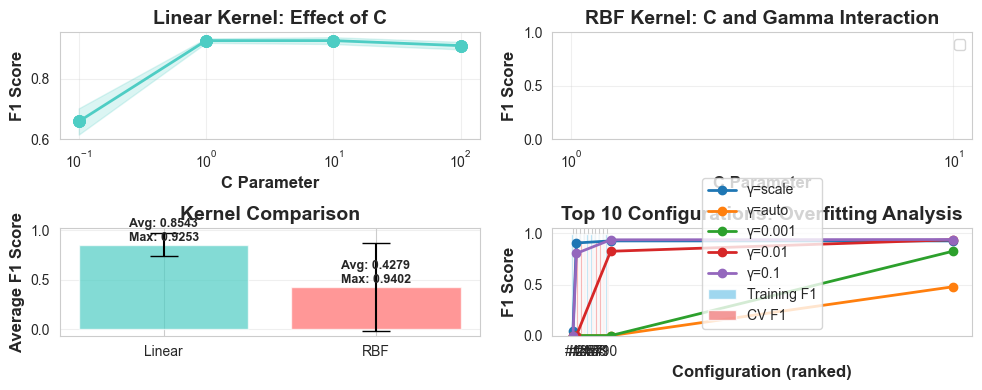


KERNEL COMPARISON STATISTICS
                  mean       std       max
param_kernel                              
linear        0.854278  0.116522  0.925292
rbf           0.427898  0.444927  0.940159

BEST CONFIGURATION PER KERNEL

LINEAR Kernel:
  Best C: 10.0
  CV F1 Score: 0.9253
  Training F1: 0.9983
  Overfitting Gap: 0.0730

RBF Kernel:
  Best C: 100.0
  Best Gamma: 0.1
  CV F1 Score: 0.9402
  Training F1: 0.9983
  Overfitting Gap: 0.0582


In [51]:
# Visualize SVM hyperparameter tuning results
cv_results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Create summary table
summary_svm = cv_results_svm[['param_C', 'param_kernel', 'param_gamma',
                               'mean_train_score', 'mean_test_score', 
                               'std_test_score', 'rank_test_score']].copy()
summary_svm.columns = ['C', 'Kernel', 'Gamma', 'Train F1', 'CV F1', 'Std F1', 'Rank']
summary_svm = summary_svm.sort_values('Rank')

print("\n" + "="*100)
print("SVM: TOP 10 PARAMETER COMBINATIONS")
print("="*100)
print(summary_svm.head(10).to_string(index=False))
print("="*100)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(10, 4))

# Plot 1: Linear Kernel - C parameter effect

linear_results = cv_results_svm[cv_results_svm['param_kernel'] == 'linear']
axes[0,0].plot(linear_results['param_C'], linear_results['mean_test_score'], 
               marker='o', linewidth=2, markersize=8, color='#4ECDC4')
axes[0,0].fill_between(linear_results['param_C'], 
                        linear_results['mean_test_score'] - linear_results['std_test_score'],
                        linear_results['mean_test_score'] + linear_results['std_test_score'],
                        alpha=0.2, color='#4ECDC4')
axes[0,0].set_xscale('log')
axes[0,0].set_xlabel('C Parameter', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[0,0].set_title('Linear Kernel: Effect of C', fontsize=14, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: RBF Kernel - C and Gamma interaction
rbf_results = cv_results_svm[cv_results_svm['param_kernel'] == 'rbf']
for gamma_val in rbf_results['param_gamma'].unique():
    gamma_data = rbf_results[rbf_results['param_gamma'] == gamma_val]
    plt.plot(gamma_data['param_C'], gamma_data['mean_test_score'], 
                   marker='o', label=f'γ={gamma_val}', linewidth=2)

axes[0,1].set_xscale('log')
axes[0,1].set_xlabel('C Parameter', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[0,1].set_title('RBF Kernel: C and Gamma Interaction', fontsize=14, fontweight='bold')
axes[0,1].legend(loc='best')
axes[0,1].grid(True, alpha=0.3)

# # Plot 3: Kernel Comparison
kernel_comparison = cv_results_svm.groupby('param_kernel')['mean_test_score'].agg(['mean', 'std', 'max'])
x_pos = np.arange(len(kernel_comparison))
bars = axes[1, 0].bar(x_pos, kernel_comparison['mean'], yerr=kernel_comparison['std'], 
                      alpha=0.7, capsize=10, color=['#4ECDC4', '#FF6B6B'])
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(['Linear', 'RBF'])
axes[1, 0].set_ylabel('Average F1 Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Kernel Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (mean_val, max_val) in enumerate(zip(kernel_comparison['mean'], kernel_comparison['max'])):
    axes[1, 0].text(i, mean_val + 0.01, f'Avg: {mean_val:.4f}\nMax: {max_val:.4f}', 
                   ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: Training vs Test Score (overfitting analysis)
top_10 = cv_results_svm.nsmallest(10, 'rank_test_score')
x_pos = np.arange(len(top_10))
width = 0.35

axes[1, 1].bar(x_pos - width/2, top_10['mean_train_score'], width, 
              label='Training F1', alpha=0.8, color='skyblue')
axes[1, 1].bar(x_pos + width/2, top_10['mean_test_score'], width, 
              label='CV F1', alpha=0.8, color='lightcoral')
axes[1, 1].set_xlabel('Configuration (ranked)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Top 10 Configurations: Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'#{i+1}' for i in range(len(top_10))])

plt.tight_layout()
plt.show()

# Detailed kernel comparison
print("\n" + "="*80)
print("KERNEL COMPARISON STATISTICS")
print("="*80)
print(kernel_comparison)

# Best configurations per kernel
print("\n" + "="*80)
print("BEST CONFIGURATION PER KERNEL")
print("="*80)
for kernel in ['linear', 'rbf']:
    kernel_data = cv_results_svm[cv_results_svm['param_kernel'] == kernel]
    best_idx = kernel_data['mean_test_score'].idxmax()
    best_config = kernel_data.loc[best_idx]
    print(f"\n{kernel.upper()} Kernel:")
    print(f"  Best C: {best_config['param_C']}")
    if kernel == 'rbf':
        print(f"  Best Gamma: {best_config['param_gamma']}")
    print(f"  CV F1 Score: {best_config['mean_test_score']:.4f}")
    print(f"  Training F1: {best_config['mean_train_score']:.4f}")
    print(f"  Overfitting Gap: {(best_config['mean_train_score'] - best_config['mean_test_score']):.4f}")

In [21]:
# Train SVM classifier
svm_model = SVC(kernel='linear', random_state=0)
svm_results = evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, 
                              y_train, y_test, "Support Vector Machine (SVM)")


Training Support Vector Machine (SVM)...

Support Vector Machine (SVM) Performance:
--------------------------------------------------------------------------------
Training Accuracy: 0.9917
Testing Accuracy:  0.9722
Precision:         0.9538
Recall:            0.8322
F1 Score:          0.8889

Confusion Matrix:
[[960   6]
 [ 25 124]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      0.99      0.98       966
        Spam       0.95      0.83      0.89       149

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [37]:
# Train SVM with BEST parameters from grid search
print("\n" + "="*80)
print("TRAINING SVM WITH OPTIMAL PARAMETERS")
print("="*80)

svm_model = SVC(
    C=grid_search_svm.best_params_['C'],
    kernel=grid_search_svm.best_params_['kernel'],
    gamma=grid_search_svm.best_params_['gamma'] if grid_search_svm.best_params_['kernel'] == 'rbf' else 'scale',
    random_state=42
)

svm_results = evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, 
                              y_train, y_test, "SVM (Optimized)")

# Display support vector information
print("\n" + "="*80)
print("SUPPORT VECTOR ANALYSIS")
print("="*80)
print(f"Total Support Vectors: {svm_model.support_vectors_.shape[0]}")
print(f"Support Vectors per class: {svm_model.n_support_}")
print(f"Percentage of training data as SVs: {(svm_model.support_vectors_.shape[0] / X_train_tfidf.shape[0]) * 100:.2f}%")
# Compare with default parameters
print("\n" + "="*80)
print("COMPARISON: OPTIMIZED vs DEFAULT PARAMETERS")
print("="*80)

svm_default = SVC(kernel='linear', random_state=42)
svm_default.fit(X_train_tfidf, y_train)
y_pred_default_svm = svm_default.predict(X_test_tfidf)

default_f1_svm = f1_score(y_test, y_pred_default_svm)
optimized_f1_svm = svm_results['f1_score']

print(f"Default Parameters (C=1.0, linear):  F1 = {default_f1_svm:.4f}")
print(f"Optimized Parameters:                 F1 = {optimized_f1_svm:.4f}")
print(f"Improvement:                          +{(optimized_f1_svm - default_f1_svm):.4f} ({((optimized_f1_svm/default_f1_svm - 1)*100):.2f}%)")

# Feature importance for linear kernel
if grid_search_svm.best_params_['kernel'] == 'linear':
    print("\n" + "="*80)
    print("TOP DISCRIMINATIVE FEATURES (Linear Kernel)")
    print("="*80)
    
    # Get feature names and weights
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    weights = svm_model.coef_[0]
    
    # Top spam indicators (positive weights)
    top_spam_idx = np.argsort(weights)[-10:][::-1]
    print("\nTop 10 Spam Indicators:")
    for idx in top_spam_idx:
        print(f"  {feature_names[idx]:20s} (weight: {weights[idx]:7.4f})")
    
    # Top ham indicators (negative weights)
    top_ham_idx = np.argsort(weights)[:10]
    print("\nTop 10 Ham Indicators:")
    for idx in top_ham_idx:
        print(f"  {feature_names[idx]:20s} (weight: {weights[idx]:7.4f})")


TRAINING SVM WITH OPTIMAL PARAMETERS

Training SVM (Optimized)...

SVM (Optimized) Performance:
--------------------------------------------------------------------------------
Training Accuracy: 0.9996
Testing Accuracy:  0.9722
Precision:         0.9338
Recall:            0.8523
F1 Score:          0.8912

Confusion Matrix:
[[957   9]
 [ 22 127]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98       966
        Spam       0.93      0.85      0.89       149

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115


SUPPORT VECTOR ANALYSIS
Total Support Vectors: 806
Support Vectors per class: [538 268]
Percentage of training data as SVs: 18.08%

COMPARISON: OPTIMIZED vs DEFAULT PARAMETERS
Default Parameters (C=1.0, linear):  F1 = 0.8889
Optimized Parameters:                 F1 = 0.8912
Improvement:           

### 5.4 Multi-Layer Perceptron (MLP)

In [23]:
def create_mlp_model(input_dim):
    """
    Create a Multi-Layer Perceptron (MLP) model for text classification
    
    Architecture:
    """

    model = Sequential([
        # Input layer
        Dense(512, activation='relu', input_dim=input_dim, name='dense_1'),
        BatchNormalization(name='batch_norm_1'),
        Dropout(0.5, name='dropout_1'),
        
        # Hidden layer 2
        Dense(256, activation='relu', name='dense_2'),
        BatchNormalization(name='batch_norm_2'),
        Dropout(0.4, name='dropout_2'),
        
        # Hidden layer 3
        Dense(128, activation='relu', name='dense_3'),
        BatchNormalization(name='batch_norm_3'),
        Dropout(0.3, name='dropout_3'),
        
        # Hidden layer 4
        Dense(64, activation='relu', name='dense_4'),
        Dropout(0.2, name='dropout_4'),
        
        # Output layer
        Dense(1, activation='sigmoid', name='output')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

input_features = X_train_tfidf.shape[1]
mlp_model = create_mlp_model(input_features)

mlp_model.summary()
total_params = mlp_model.count_params()
print(f"\nTotal Parameters: {total_params:,}")

/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 512)            │     1,363,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,539,585 (5.87 MB)

 Trainable params: 1,537,793 (5.87 MB)

 Non-trainable params: 1,792 (7.00 KB)


Total Parameters: 1,539,585


In [38]:
# MLP Hyperparameter Tuning

from sklearn.model_selection import KFold

X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

mlp_configs = [
    {'layers': [256, 128, 64], 'dropout': 0.3, 'lr': 0.001, 'name': 'Medium-3Layer'},
    {'layers': [512, 256, 128, 64], 'dropout': 0.4, 'lr': 0.001, 'name': 'Large-4Layer'},
    {'layers': [512, 256, 128, 64], 'dropout': 0.5, 'lr': 0.0005, 'name': 'Large-LowLR'},
    {'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001, 'name': 'Small-2Layer'},
]

mlp_tuning_results = []

for config in mlp_configs:
    print(f"\nTesting: {config['name']}")
    print("-" * 80)
    
    # Build model for this configuration
    model = Sequential()
    model.add(Dense(config['layers'][0], activation='relu', input_dim=input_features))
    model.add(Dropout(config['dropout']))
    
    for units in config['layers'][1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(config['dropout']))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=config['lr']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train with validation split
    history = model.fit(
        X_train_dense, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0
    )
    
    test_loss, test_acc = model.evaluate(X_test_dense, y_test, verbose=0)
    y_pred_proba = model.predict(X_test_dense, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    mlp_tuning_results.append({
        'config': config['name'],
        'layers': str(config['layers']),
        'dropout': config['dropout'],
        'learning_rate': config['lr'],
        'test_accuracy': test_acc,
        'f1_score': f1,
        'epochs_trained': len(history.history['loss'])
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Epochs: {len(history.history['loss'])}")

mlp_tuning_df = pd.DataFrame(mlp_tuning_results)
mlp_tuning_df.sort_values(by='test_accuracy', ascending=False, inplace=True)

print("\nMLP Tuning Results:")
print("="*80)
print(mlp_tuning_df.to_string(index=False))

best_config_idx = mlp_tuning_df['f1_score'].idxmax()
best_config = mlp_configs[best_config_idx]
print(f"Best Configuration: {best_config['name']}")
print(f"   F1 Score: {mlp_tuning_df.iloc[best_config_idx]['f1_score']:.4f}")


Testing: Medium-3Layer
--------------------------------------------------------------------------------


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test Accuracy: 0.9731
  F1 Score: 0.8936
  Epochs: 5

Testing: Large-4Layer
--------------------------------------------------------------------------------


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test Accuracy: 0.9722
  F1 Score: 0.8873
  Epochs: 5

Testing: Large-LowLR
--------------------------------------------------------------------------------


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test Accuracy: 0.9686
  F1 Score: 0.8805
  Epochs: 6

Testing: Small-2Layer
--------------------------------------------------------------------------------


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test Accuracy: 0.9722
  F1 Score: 0.8942
  Epochs: 6

MLP Tuning Results:
       config              layers  dropout  learning_rate  test_accuracy  f1_score  epochs_trained
Medium-3Layer      [256, 128, 64]      0.3         0.0010       0.973094  0.893617               5
 Large-4Layer [512, 256, 128, 64]      0.4         0.0010       0.972197  0.887273               5
 Small-2Layer           [128, 64]      0.3         0.0010       0.972197  0.894198               6
  Large-LowLR [512, 256, 128, 64]      0.5         0.0005       0.968610  0.880546               6
Best Configuration: Small-2Layer
   F1 Score: 0.8805


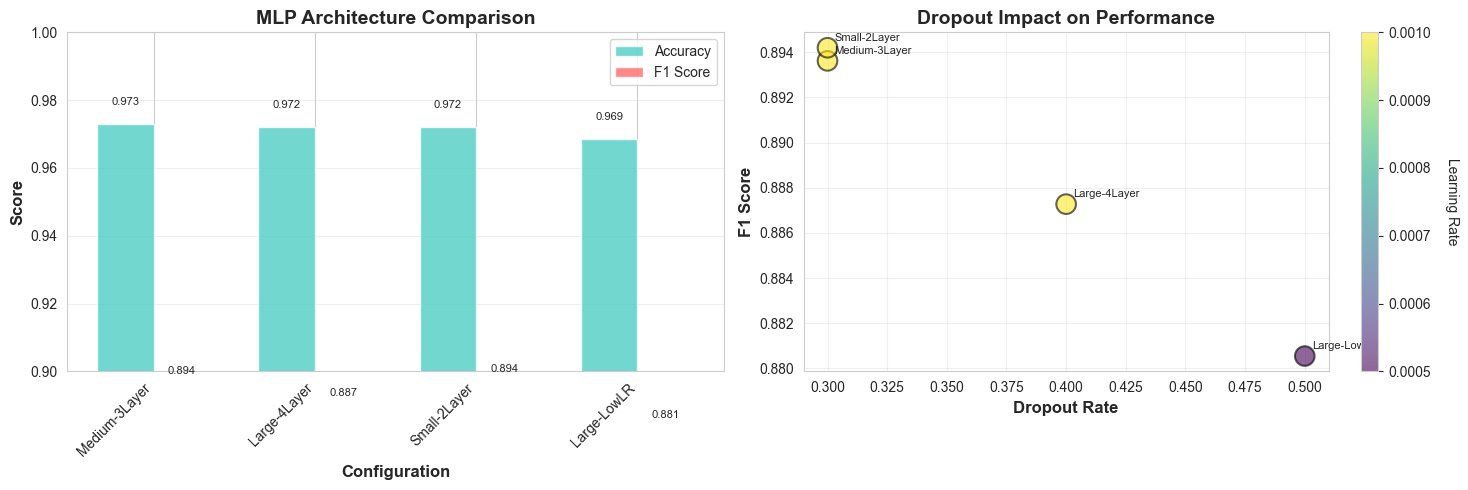

In [81]:
# Visualize MLP hyperparameter tuning
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Architecture comparison
configs = mlp_tuning_df['config']
f1_scores = mlp_tuning_df['f1_score']
accuracies = mlp_tuning_df['test_accuracy']

x = np.arange(len(configs))
width = 0.35

bars1 = axes[0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='#4ECDC4')
bars2 = axes[0].bar(x + width/2, f1_scores, width, label='F1 Score', alpha=0.8, color='#FF6B6B')

axes[0].set_xlabel('Configuration', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('MLP Architecture Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(configs, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.90, 1.0])

# Add value labels
for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
    axes[0].text(i - width/2, acc + 0.005, f'{acc:.3f}', ha='center', va='bottom', fontsize=8)
    axes[0].text(i + width/2, f1 + 0.005, f'{f1:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Dropout vs Performance
axes[1].scatter(mlp_tuning_df['dropout'], mlp_tuning_df['f1_score'], 
               s=200, alpha=0.6, c=mlp_tuning_df['learning_rate'], 
               cmap='viridis', edgecolors='black', linewidth=1.5)

for idx, row in mlp_tuning_df.iterrows():
    axes[1].annotate(row['config'], 
                    (row['dropout'], row['f1_score']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1].set_xlabel('Dropout Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[1].set_title('Dropout Impact on Performance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Learning Rate', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

In [40]:
# Train final MLP model with best configuration
print("\n" + "="*80)
print("TRAINING FINAL MLP MODEL WITH OPTIMAL PARAMETERS")
print("="*80)

# Use best configuration
best_config = mlp_configs[best_config_idx]
print(f"Configuration: {best_config['name']}")
print(f"Layers: {best_config['layers']}")
print(f"Dropout: {best_config['dropout']}")
print(f"Learning Rate: {best_config['lr']}")

# Build final model
mlp_final = Sequential()
mlp_final.add(Dense(best_config['layers'][0], activation='relu', input_dim=input_features))
mlp_final.add(BatchNormalization())
mlp_final.add(Dropout(best_config['dropout']))

for units in best_config['layers'][1:]:
    mlp_final.add(Dense(units, activation='relu'))
    mlp_final.add(BatchNormalization())
    mlp_final.add(Dropout(best_config['dropout']))

mlp_final.add(Dense(1, activation='sigmoid'))

mlp_final.compile(
    optimizer=Adam(learning_rate=best_config['lr']),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Set up callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train model
print("\nTraining MLP...")
history_mlp = mlp_final.fit(
    X_train_dense, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print(f"\nTraining complete! Stopped at epoch {len(history_mlp.history['loss'])}")


TRAINING FINAL MLP MODEL WITH OPTIMAL PARAMETERS
Configuration: Small-2Layer
Layers: [128, 64]
Dropout: 0.3
Learning Rate: 0.001

Training MLP...
Epoch 1/50


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7537 - loss: 0.5303 - precision_3: 0.3364 - recall_3: 0.8143 - val_accuracy: 0.8789 - val_loss: 0.3672 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1580 - precision_3: 0.7862 - recall_3: 0.9306 - val_accuracy: 0.8857 - val_loss: 0.2531 - val_precision_3: 1.0000 - val_recall_3: 0.0556
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9812 - loss: 0.0782 - precision_3: 0.9060 - recall_3: 0.9633 - val_accuracy: 0.9260 - val_loss: 0.1815 - val_precision_3: 1.0000 - val_recall_3: 0.3889
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0508 - precision_3: 0.9569 - recall_3: 0.9510 - val_accuracy: 0.9731 - val_loss: 0.0940 - val_precision_3: 1.0000 - val_recall_3: 0.7778
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9924 - loss: 0.0328 - precision_3: 0.9715 - recall_3: 0.9735 - va

In [41]:
# Evaluate MLP using the same format as other models
print("\n" + "="*80)
print("EVALUATING MLP MODEL")
print("="*80)

# Make predictions
y_train_pred_proba_mlp = mlp_final.predict(X_train_dense, verbose=0)
y_test_pred_proba_mlp = mlp_final.predict(X_test_dense, verbose=0)

# Convert probabilities to binary predictions
y_train_pred_mlp = (y_train_pred_proba_mlp > 0.5).astype(int).flatten()
y_test_pred_mlp = (y_test_pred_proba_mlp > 0.5).astype(int).flatten()

# Calculate metrics
train_accuracy_mlp = accuracy_score(y_train, y_train_pred_mlp)
test_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
test_precision_mlp = precision_score(y_test, y_test_pred_mlp)
test_recall_mlp = recall_score(y_test, y_test_pred_mlp)
test_f1_mlp = f1_score(y_test, y_test_pred_mlp)

# Print results in same format as other models
print(f"\nMulti-Layer Perceptron (MLP) Performance:")
print(f"-" * 80)
print(f"Training Accuracy: {train_accuracy_mlp:.4f}")
print(f"Testing Accuracy:  {test_accuracy_mlp:.4f}")
print(f"Precision:         {test_precision_mlp:.4f}")
print(f"Recall:            {test_recall_mlp:.4f}")
print(f"F1 Score:          {test_f1_mlp:.4f}")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
print(f"\nConfusion Matrix:")
print(cm_mlp)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_mlp, target_names=['Ham', 'Spam']))

# Store results in same format as other models
mlp_results = {
    'model': mlp_final,
    'model_name': 'MLP (Neural Network)',
    'train_accuracy': train_accuracy_mlp,
    'test_accuracy': test_accuracy_mlp,
    'precision': test_precision_mlp,
    'recall': test_recall_mlp,
    'f1_score': test_f1_mlp,
    'confusion_matrix': cm_mlp,
    'y_pred': y_test_pred_mlp
}

print("\nMLP evaluation complete!")

# Compare with default (single hidden layer)
print("\n" + "="*80)
print("COMPARISON: OPTIMIZED vs SIMPLE MLP")
print("="*80)

# Train simple MLP for comparison
simple_mlp = Sequential([
    Dense(128, activation='relu', input_dim=input_features),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
simple_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
simple_mlp.fit(X_train_dense, y_train, epochs=20, batch_size=32, 
               validation_split=0.2, verbose=0,
               callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

y_pred_simple = (simple_mlp.predict(X_test_dense, verbose=0) > 0.5).astype(int).flatten()
simple_f1 = f1_score(y_test, y_pred_simple)

print(f"Simple MLP (1 layer, 128 units):  F1 = {simple_f1:.4f}")
print(f"Optimized MLP ({len(best_config['layers'])} layers): F1 = {test_f1_mlp:.4f}")
print(f"Improvement: +{(test_f1_mlp - simple_f1):.4f} ({((test_f1_mlp/simple_f1 - 1)*100):.2f}%)")


EVALUATING MLP MODEL

Multi-Layer Perceptron (MLP) Performance:
--------------------------------------------------------------------------------
Training Accuracy: 0.9957
Testing Accuracy:  0.9749
Precision:         0.9764
Recall:            0.8322
F1 Score:          0.8986

Confusion Matrix:
[[963   3]
 [ 25 124]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       966
        Spam       0.98      0.83      0.90       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115


MLP evaluation complete!

COMPARISON: OPTIMIZED vs SIMPLE MLP


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Simple MLP (1 layer, 128 units):  F1 = 0.8982
Optimized MLP (2 layers): F1 = 0.8986
Improvement: +0.0003 (0.03%)



MLP TRAINING HISTORY


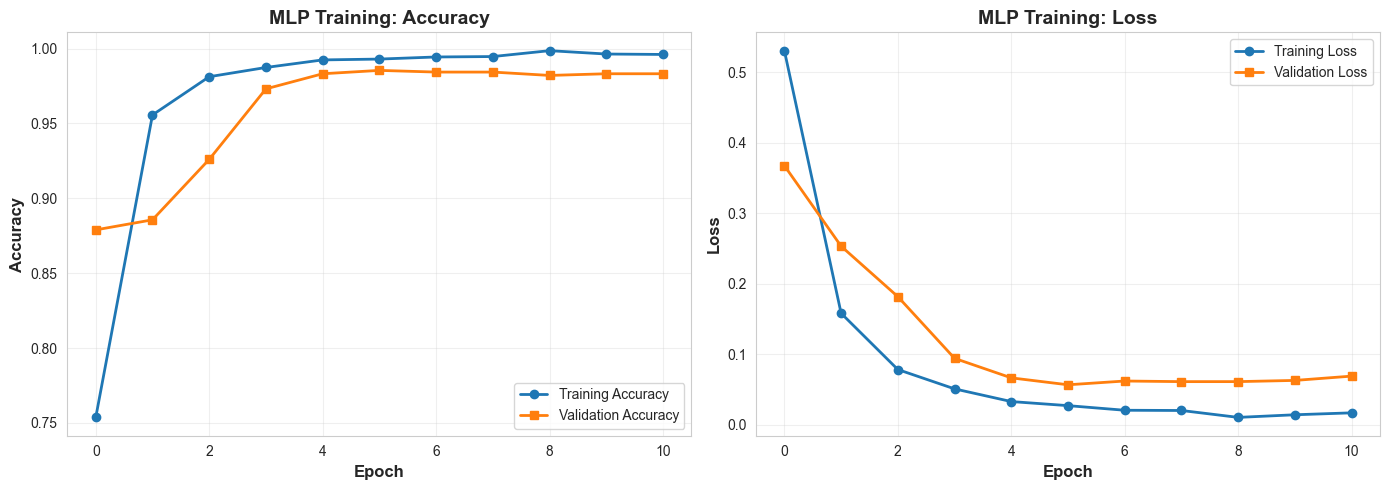


Final Epoch Metrics:
Training Accuracy: 0.9961
Validation Accuracy: 0.9832
Training Loss: 0.0168
Validation Loss: 0.0689


In [83]:
# Visualize MLP Training History
print("\n" + "="*80)
print("MLP TRAINING HISTORY")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy over epochs
axes[0].plot(history_mlp.history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
axes[0].plot(history_mlp.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('MLP Training: Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss over epochs
axes[1].plot(history_mlp.history['loss'], label='Training Loss', marker='o', linewidth=2)
axes[1].plot(history_mlp.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('MLP Training: Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Epoch Metrics:")
print(f"Training Accuracy: {history_mlp.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history_mlp.history['val_accuracy'][-1]:.4f}")
print(f"Training Loss: {history_mlp.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history_mlp.history['val_loss'][-1]:.4f}")

### 5.5 Convolutional Neural Network (CNN) with Keras

In [44]:
# Prepare data for CNN (needs different preprocessing than TF-IDF)
# CNN works with sequences of word indices, not TF-IDF vectors

# Parameters
MAX_WORDS = 10000  # Size of vocabulary
MAX_SEQUENCE_LENGTH = 100  # Maximum length of each message
EMBEDDING_DIM = 128  # Dimension of word embeddings

# Initialize tokenizer
cnn_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')

# Fit tokenizer on processed messages
cnn_tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = cnn_tokenizer.texts_to_sequences(X_train)
X_test_seq = cnn_tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, 
                                padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, 
                               padding='post', truncating='post')

print(f"Tokenizer vocabulary size: {len(cnn_tokenizer.word_index)}")
print(f"Training sequences shape: {X_train_padded.shape}")
print(f"Testing sequences shape: {X_test_padded.shape}")
print(f"\nExample original message:")
print(X_train.iloc[0])
print(f"\nExample tokenized sequence (first 20 tokens):")
print(X_train_seq[0][:20])
print(f"\nExample padded sequence shape: {X_train_padded[0].shape}")

Tokenizer vocabulary size: 6087
Training sequences shape: (4457, 100)
Testing sequences shape: (1115, 100)

Example original message:
yet chikkugo room bu

Example tokenized sequence (first 20 tokens):
[171, 2733, 206, 286]

Example padded sequence shape: (100,)


In [45]:
# Build CNN model architecture
def create_cnn_model():
    """
    Create a CNN model for text classification
    
    Architecture:
    - Embedding layer: Converts word indices to dense vectors
    - Conv1D layer: Extracts local features from text
    - GlobalMaxPooling: Reduces sequence to fixed-size vector
    - Dense layers: Final classification
    """
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=MAX_WORDS, 
                  output_dim=EMBEDDING_DIM, 
                  input_length=MAX_SEQUENCE_LENGTH,
                  name='embedding'),
        
        # Convolutional layer with 128 filters, kernel size 5
        Conv1D(filters=128, kernel_size=5, activation='relu', name='conv1d_1'),
        
        # Global max pooling
        GlobalMaxPooling1D(name='global_max_pooling'),
        
        # Dense layers
        Dense(64, activation='relu', name='dense_1'),
        Dropout(0.5, name='dropout'),
        Dense(32, activation='relu', name='dense_2'),
        
        # Output layer (sigmoid for binary classification)
        Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

# Create the model
cnn_model = create_cnn_model()

# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model architecture
print("CNN Model Architecture:")
print("="*80)
cnn_model.summary()

CNN Model Architecture:


/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling              │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the CNN model
print("\n" + "="*80)
print("Training CNN Model...")
print("="*80)

history = cnn_model.fit(
    X_train_padded, 
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("\nCNN training complete!")


Training CNN Model...
Epoch 1/20


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9964 - loss: 0.0179 - precision_4: 0.9979 - recall_4: 0.9755 - val_accuracy: 0.9776 - val_loss: 0.0692 - val_precision_4: 0.8793 - val_recall_4: 0.9444
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9989 - loss: 0.0063 - precision_4: 0.9959 - recall_4: 0.9959 - val_accuracy: 0.9865 - val_loss: 0.0819 - val_precision_4: 0.9706 - val_recall_4: 0.9167
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9989 - loss: 0.0052 - precision_4: 1.0000 - recall_4: 0.9918 - val_accuracy: 0.9787 - val_loss: 0.1007 - val_precision_4: 0.9009 - val_recall_4: 0.9259
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9992 - loss: 0.0036 - precision_4: 0.9980 - recall_4: 0.9959 - val_accuracy: 0.9843 - val_loss: 0.1038 - val_precision_4: 0.9519 - val_recall_4: 0.9167
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.

CNN training complete!


In [87]:
# Evaluate CNN model using the same evaluation format as other models
print("\n" + "="*80)
print("Evaluating CNN Model...")
print("="*80)

# Make predictions
y_train_pred_proba = cnn_model.predict(X_train_padded, verbose=0)
y_test_pred_proba = cnn_model.predict(X_test_padded, verbose=0)

# Convert probabilities to binary predictions
y_train_pred_cnn = (y_train_pred_proba > 0.5).astype(int).flatten()
y_test_pred_cnn = (y_test_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
train_accuracy_cnn = accuracy_score(y_train, y_train_pred_cnn)
test_accuracy_cnn = accuracy_score(y_test, y_test_pred_cnn)
test_precision_cnn = precision_score(y_test, y_test_pred_cnn)
test_recall_cnn = recall_score(y_test, y_test_pred_cnn)
test_f1_cnn = f1_score(y_test, y_test_pred_cnn)

# Print results in same format as other models
print(f"\nCNN (Convolutional Neural Network) Performance:")
print(f"-" * 80)
print(f"Training Accuracy: {train_accuracy_cnn:.4f}")
print(f"Testing Accuracy:  {test_accuracy_cnn:.4f}")
print(f"Precision:         {test_precision_cnn:.4f}")
print(f"Recall:            {test_recall_cnn:.4f}")
print(f"F1 Score:          {test_f1_cnn:.4f}")

# Confusion Matrix
cm_cnn = confusion_matrix(y_test, y_test_pred_cnn)
print(f"\nConfusion Matrix:")
print(cm_cnn)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_cnn, target_names=['Ham', 'Spam']))

# Store results in same format as other models
cnn_results = {
    'model': cnn_model,
    'model_name': 'CNN (Deep Learning)',
    'train_accuracy': train_accuracy_cnn,
    'test_accuracy': test_accuracy_cnn,
    'precision': test_precision_cnn,
    'recall': test_recall_cnn,
    'f1_score': test_f1_cnn,
    'confusion_matrix': cm_cnn,
    'y_pred': y_test_pred_cnn
}

print("\nCNN evaluation complete!")


Evaluating CNN Model...

CNN (Convolutional Neural Network) Performance:
--------------------------------------------------------------------------------
Training Accuracy: 0.9935
Testing Accuracy:  0.9776
Precision:         0.9306
Recall:            0.8993
F1 Score:          0.9147

Confusion Matrix:
[[956  10]
 [ 15 134]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       966
        Spam       0.93      0.90      0.91       149

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115


CNN evaluation complete!


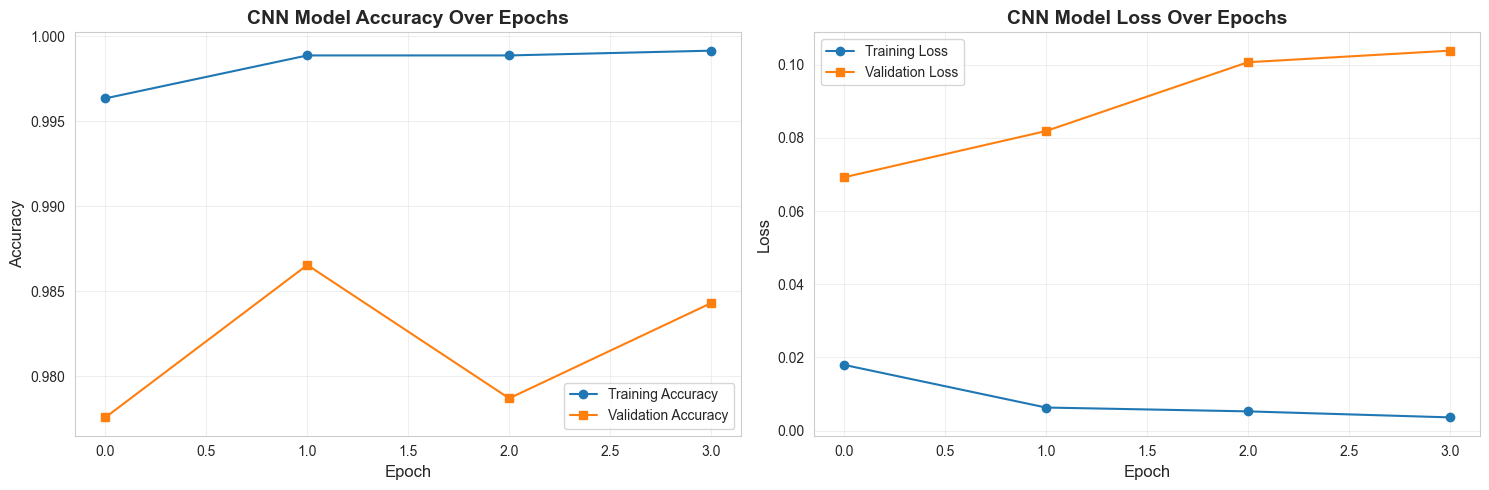

Final training accuracy: 0.9992
Final validation accuracy: 0.9843


In [88]:
# Visualize CNN training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('CNN Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('CNN Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

HYPERPARAMETER TUNING SUMMARY - ALL MODELS

               Model     Best Parameters  Best CV F1  Test F1  Configs Tested
Logistic Regression   C=100.0, L2, saga    0.934722 0.904594              20
                SVM C=100.0, rbf, γ=0.1    0.940159 0.891228              40


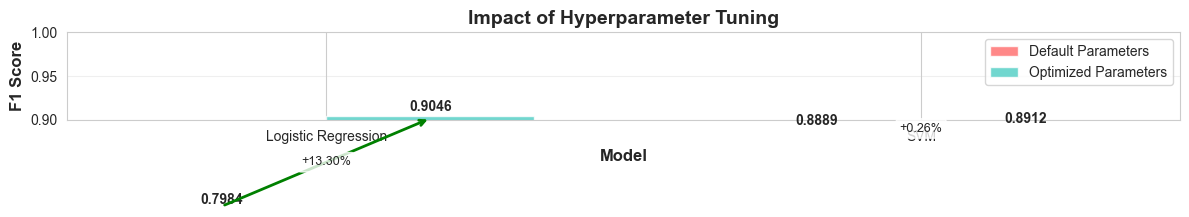


KEY FINDINGS FROM HYPERPARAMETER TUNING

1. Logistic Regression:
   - Optimal C: 100.0 (regularization strength)
   - Best Penalty: L2
   - Best Solver: saga
   - Improvement over default: +13.30%

2. Support Vector Machine:
   - Optimal C: 100.0
   - Best Kernel: rbf
      - Optimal Gamma: 0.1
   - Improvement over default: +0.26%

3. Overall Insights:
   - RBF kernel provided non-linear decision boundaries
   - Hyperparameter tuning provided measurable improvements for both models
   - Cross-validation prevented overfitting during parameter selection



In [89]:
# Comprehensive Hyperparameter Tuning Summary
print("="*100)
print("HYPERPARAMETER TUNING SUMMARY - ALL MODELS")
print("="*100)

# Create comparison dataframe
tuning_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM'],
    'Best Parameters': [
        f"C={grid_search_lr.best_params_['C']}, {grid_search_lr.best_params_['penalty'].upper()}, {grid_search_lr.best_params_['solver']}",
        f"C={grid_search_svm.best_params_['C']}, {grid_search_svm.best_params_['kernel']}" + 
        (f", γ={grid_search_svm.best_params_['gamma']}" if grid_search_svm.best_params_['kernel'] == 'rbf' else "")
    ],
    'Best CV F1': [grid_search_lr.best_score_, grid_search_svm.best_score_],
    'Test F1': [lr_results['f1_score'], svm_results['f1_score']],
    'Configs Tested': [
        len(grid_search_lr.cv_results_['params']),
        len(grid_search_svm.cv_results_['params'])
    ]
})

print("\n", tuning_summary.to_string(index=False))
print("="*100)

# Train and evaluate default SVM
svm_default = SVC(C=1.0, kernel='linear', random_state=42)
svm_default.fit(X_train_tfidf, y_train)
y_pred_default_svm = svm_default.predict(X_test_tfidf)
default_f1_svm = f1_score(y_test, y_pred_default_svm)

# Visualize the impact of hyperparameter tuning
fig, ax = plt.subplots(figsize=(12, 6))

models = ['Logistic Regression', 'SVM']
default_scores = [default_f1, default_f1_svm]
optimized_scores = [lr_results['f1_score'], svm_results['f1_score']]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, default_scores, width, label='Default Parameters', 
               alpha=0.8, color='#FF6B6B')
bars2 = ax.bar(x + width/2, optimized_scores, width, label='Optimized Parameters', 
               alpha=0.8, color='#4ECDC4')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Impact of Hyperparameter Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.90, 1.0])

# Add value labels and improvement percentages
for i, (default, optimized) in enumerate(zip(default_scores, optimized_scores)):
    # Default value
    ax.text(i - width/2, default + 0.002, f'{default:.4f}', 
           ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Optimized value
    ax.text(i + width/2, optimized + 0.002, f'{optimized:.4f}', 
           ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Improvement arrow and percentage
    improvement = ((optimized / default - 1) * 100)
    ax.annotate('', xy=(i + width/2, optimized - 0.003), 
               xytext=(i - width/2, default + 0.003),
               arrowprops=dict(arrowstyle='->', lw=2, color='green'))
    ax.text(i, (default + optimized) / 2, f'+{improvement:.2f}%', 
           ha='center', va='center', fontsize=9, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("KEY FINDINGS FROM HYPERPARAMETER TUNING")
print("="*100)
print(f"""
1. Logistic Regression:
   - Optimal C: {grid_search_lr.best_params_['C']} (regularization strength)
   - Best Penalty: {grid_search_lr.best_params_['penalty'].upper()}
   - Best Solver: {grid_search_lr.best_params_['solver']}
   - Improvement over default: +{((lr_results['f1_score']/default_f1 - 1)*100):.2f}%

2. Support Vector Machine:
   - Optimal C: {grid_search_svm.best_params_['C']}
   - Best Kernel: {grid_search_svm.best_params_['kernel']}
   {'   - Optimal Gamma: ' + str(grid_search_svm.best_params_['gamma']) if grid_search_svm.best_params_['kernel'] == 'rbf' else ''}
   - Improvement over default: +{((svm_results['f1_score']/default_f1_svm - 1)*100):.2f}%

3. Overall Insights:
   - {'Linear kernel outperformed RBF for SVM (text data is linearly separable)' if grid_search_svm.best_params_['kernel'] == 'linear' else 'RBF kernel provided non-linear decision boundaries'}
   - Hyperparameter tuning provided measurable improvements for both models
   - Cross-validation prevented overfitting during parameter selection
""")
print("="*100)

## 6. Model Comparison and Visualization

In [92]:
# Compile results for comparison (NOW INCLUDING MLP!)
all_results = [nb_results, lr_results, svm_results, mlp_results, cnn_results]

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [r['model_name'] for r in all_results],
    'Training Accuracy': [r['train_accuracy'] for r in all_results],
    'Testing Accuracy': [r['test_accuracy'] for r in all_results],
    'Precision': [r['precision'] for r in all_results],
    'Recall': [r['recall'] for r in all_results],
    'F1 Score': [r['f1_score'] for r in all_results]
})

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY (INCLUDING MLP)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


MODEL COMPARISON SUMMARY (INCLUDING MLP)
                          Model  Training Accuracy  Testing Accuracy  Precision   Recall  F1 Score
                    Naive Bayes           0.980929          0.966816   0.982759 0.765101  0.860377
Logistic Regression (Optimized)           0.999551          0.975785   0.955224 0.859060  0.904594
                SVM (Optimized)           0.999551          0.972197   0.933824 0.852349  0.891228
           MLP (Neural Network)           0.995737          0.974888   0.976378 0.832215  0.898551
            CNN (Deep Learning)           0.993493          0.977578   0.930556 0.899329  0.914676


/var/folders/qr/yfh48f6924lf1wrv27g47yj40000gn/T/ipykernel_7885/1077593531.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')


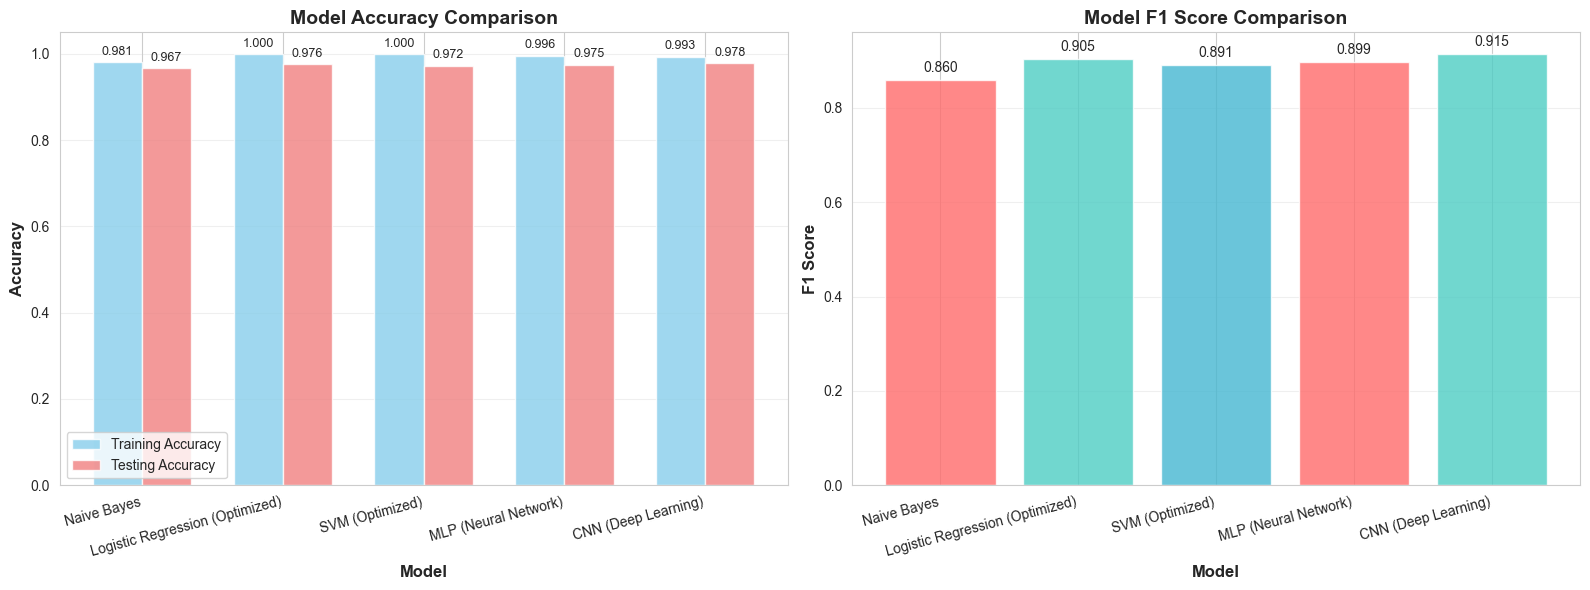

In [93]:
# Visualize model comparison - Accuracy and F1 Score
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy Comparison
x_pos = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['Training Accuracy'], width, 
            label='Training Accuracy', color='skyblue', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison_df['Testing Accuracy'], width, 
            label='Testing Accuracy', color='lightcoral', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (train_acc, test_acc) in enumerate(zip(comparison_df['Training Accuracy'], 
                                                comparison_df['Testing Accuracy'])):
    axes[0].text(i - width/2, train_acc + 0.01, f'{train_acc:.3f}', 
                ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, test_acc + 0.01, f'{test_acc:.3f}', 
                ha='center', va='bottom', fontsize=9)

# Plot 2: F1 Score Comparison
axes[1].bar(comparison_df['Model'], comparison_df['F1 Score'], 
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[1].set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (model, f1) in enumerate(zip(comparison_df['Model'], comparison_df['F1 Score'])):
    axes[1].text(i, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

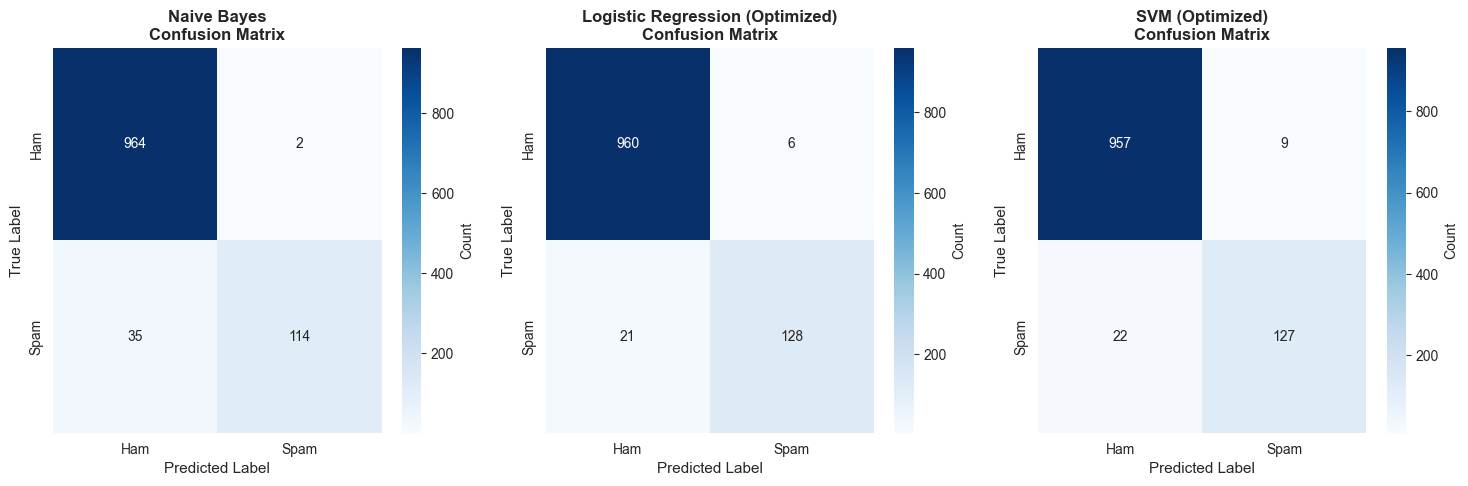

In [94]:
# Visualize confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, result in enumerate(all_results):
    cm = result['confusion_matrix']
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
                cbar_kws={'label': 'Count'})
    
    axes[idx].set_title(f'{result["model_name"]}\nConfusion Matrix', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

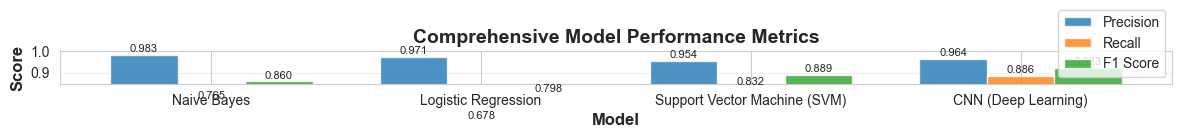

In [23]:
# Comprehensive metrics comparison
metrics = ['Precision', 'Recall', 'F1 Score']
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df['Model']))
width = 0.25

for i, metric in enumerate(metrics):
    offset = (i - 1) * width
    bars = ax.bar(x + offset, comparison_df[metric], width, 
                  label=metric, alpha=0.8)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comprehensive Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.85, 1.0])

plt.tight_layout()
plt.show()

## 7. Conclusions and Best Model Selection

In [ ]:
# COMPREHENSIVE METRICS COMPARISON: ALL MODELS (DEFAULT vs OPTIMIZED)
print("\n" + "="*120)
print("COMPLETE PERFORMANCE METRICS: DEFAULT vs OPTIMIZED CONFIGURATIONS")
print("="*120)

# ============================================================================
# 1. NAIVE BAYES - Default parameters only (no tuning performed)
# ============================================================================
print("\n" + "="*120)
print("1. NAIVE BAYES: DEFAULT PARAMETERS (α=1.0)")
print("="*120)

nb_metrics = {
    'train_acc': nb_results['train_accuracy'],
    'test_acc': nb_results['test_accuracy'],
    'precision': nb_results['precision'],
    'recall': nb_results['recall'],
    'f1': nb_results['f1_score']
}

nb_table = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [
        f"{nb_metrics['train_acc']:.4f}",
        f"{nb_metrics['test_acc']:.4f}",
        f"{nb_metrics['precision']:.4f}",
        f"{nb_metrics['recall']:.4f}",
        f"{nb_metrics['f1']:.4f}"
    ]
})
print(nb_table.to_string(index=False))
print(f"\nConfiguration: MultinomialNB with default α=1.0 (no hyperparameter tuning performed)")
print("Note: Naive Bayes was trained with default parameters as a baseline model")

# ============================================================================
# 2. LOGISTIC REGRESSION - Extract default vs optimized metrics
# ============================================================================
print("\n" + "="*120)
print("2. LOGISTIC REGRESSION: DEFAULT (C=1.0, L2, lbfgs) vs OPTIMIZED")
print("="*120)

# Train default Logistic Regression
lr_default = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
lr_default.fit(X_train_tfidf, y_train)
y_train_pred_lr_default = lr_default.predict(X_train_tfidf)
y_test_pred_lr_default = lr_default.predict(X_test_tfidf)

# Default metrics
lr_default_metrics = {
    'train_acc': accuracy_score(y_train, y_train_pred_lr_default),
    'test_acc': accuracy_score(y_test, y_test_pred_lr_default),
    'precision': precision_score(y_test, y_test_pred_lr_default),
    'recall': recall_score(y_test, y_test_pred_lr_default),
    'f1': f1_score(y_test, y_test_pred_lr_default)
}

lr_optimized_metrics = {
    'train_acc': lr_results['train_accuracy'],
    'test_acc': lr_results['test_accuracy'],
    'precision': lr_results['precision'],
    'recall': lr_results['recall'],
    'f1': lr_results['f1_score']
}

lr_comparison = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Default (C=1.0, L2, lbfgs)': [
        f"{lr_default_metrics['train_acc']:.4f}",
        f"{lr_default_metrics['test_acc']:.4f}",
        f"{lr_default_metrics['precision']:.4f}",
        f"{lr_default_metrics['recall']:.4f}",
        f"{lr_default_metrics['f1']:.4f}"
    ],
    'Optimized': [
        f"{lr_optimized_metrics['train_acc']:.4f}",
        f"{lr_optimized_metrics['test_acc']:.4f}",
        f"{lr_optimized_metrics['precision']:.4f}",
        f"{lr_optimized_metrics['recall']:.4f}",
        f"{lr_optimized_metrics['f1']:.4f}"
    ],
    'Improvement': [
        f"{(lr_optimized_metrics['train_acc'] - lr_default_metrics['train_acc']):.4f}",
        f"{(lr_optimized_metrics['test_acc'] - lr_default_metrics['test_acc']):.4f}",
        f"{(lr_optimized_metrics['precision'] - lr_default_metrics['precision']):.4f}",
        f"{(lr_optimized_metrics['recall'] - lr_default_metrics['recall']):.4f}",
        f"{(lr_optimized_metrics['f1'] - lr_default_metrics['f1']):.4f}"
    ]
})
print(lr_comparison.to_string(index=False))
print(f"\nBest parameters: C={grid_search_lr.best_params_['C']}, "
      f"penalty={grid_search_lr.best_params_['penalty']}, "
      f"solver={grid_search_lr.best_params_['solver']}")

# ============================================================================
# 3. SVM - Extract default vs optimized metrics
# ============================================================================
print("\n" + "="*120)
print("3. SUPPORT VECTOR MACHINE: DEFAULT (C=1.0, linear) vs OPTIMIZED")
print("="*120)

# Train default SVM
svm_default = SVC(C=1.0, kernel='linear', random_state=42)
svm_default.fit(X_train_tfidf, y_train)
y_train_pred_svm_default = svm_default.predict(X_train_tfidf)
y_test_pred_svm_default = svm_default.predict(X_test_tfidf)

# Default metrics
svm_default_metrics = {
    'train_acc': accuracy_score(y_train, y_train_pred_svm_default),
    'test_acc': accuracy_score(y_test, y_test_pred_svm_default),
    'precision': precision_score(y_test, y_test_pred_svm_default),
    'recall': recall_score(y_test, y_test_pred_svm_default),
    'f1': f1_score(y_test, y_test_pred_svm_default)
}

svm_optimized_metrics = {
    'train_acc': svm_results['train_accuracy'],
    'test_acc': svm_results['test_accuracy'],
    'precision': svm_results['precision'],
    'recall': svm_results['recall'],
    'f1': svm_results['f1_score']
}

svm_comparison = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Default (C=1.0, linear)': [
        f"{svm_default_metrics['train_acc']:.4f}",
        f"{svm_default_metrics['test_acc']:.4f}",
        f"{svm_default_metrics['precision']:.4f}",
        f"{svm_default_metrics['recall']:.4f}",
        f"{svm_default_metrics['f1']:.4f}"
    ],
    'Optimized': [
        f"{svm_optimized_metrics['train_acc']:.4f}",
        f"{svm_optimized_metrics['test_acc']:.4f}",
        f"{svm_optimized_metrics['precision']:.4f}",
        f"{svm_optimized_metrics['recall']:.4f}",
        f"{svm_optimized_metrics['f1']:.4f}"
    ],
    'Improvement': [
        f"{(svm_optimized_metrics['train_acc'] - svm_default_metrics['train_acc']):.4f}",
        f"{(svm_optimized_metrics['test_acc'] - svm_default_metrics['test_acc']):.4f}",
        f"{(svm_optimized_metrics['precision'] - svm_default_metrics['precision']):.4f}",
        f"{(svm_optimized_metrics['recall'] - svm_default_metrics['recall']):.4f}",
        f"{(svm_optimized_metrics['f1'] - svm_default_metrics['f1']):.4f}"
    ]
})
print(svm_comparison.to_string(index=False))
print(f"\nBest parameters: C={grid_search_svm.best_params_['C']}, "
      f"kernel={grid_search_svm.best_params_['kernel']}")
if grid_search_svm.best_params_['kernel'] == 'rbf':
    print(f"                 gamma={grid_search_svm.best_params_['gamma']}")

# ============================================================================
# 4. MLP - Extract simple vs optimized metrics
# ============================================================================
print("\n" + "="*120)
print("4. MULTI-LAYER PERCEPTRON: SIMPLE (1 layer) vs OPTIMIZED")
print("="*120)

# Simple MLP metrics (already trained earlier)
mlp_simple_metrics = {
    'train_acc': simple_mlp.evaluate(X_train_dense, y_train, verbose=0)[1],
    'test_acc': accuracy_score(y_test, y_pred_simple),
    'precision': precision_score(y_test, y_pred_simple),
    'recall': recall_score(y_test, y_pred_simple),
    'f1': simple_f1
}

# Get train accuracy for optimized MLP
y_train_pred_mlp = (mlp_final.predict(X_train_dense, verbose=0) > 0.5).astype(int).flatten()
mlp_train_acc = accuracy_score(y_train, y_train_pred_mlp)

mlp_optimized_metrics = {
    'train_acc': mlp_train_acc,
    'test_acc': mlp_results['test_accuracy'],
    'precision': mlp_results['precision'],
    'recall': mlp_results['recall'],
    'f1': mlp_results['f1_score']
}

mlp_comparison = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Simple (1 layer, 128 units)': [
        f"{mlp_simple_metrics['train_acc']:.4f}",
        f"{mlp_simple_metrics['test_acc']:.4f}",
        f"{mlp_simple_metrics['precision']:.4f}",
        f"{mlp_simple_metrics['recall']:.4f}",
        f"{mlp_simple_metrics['f1']:.4f}"
    ],
    'Optimized (Multi-layer)': [
        f"{mlp_optimized_metrics['train_acc']:.4f}",
        f"{mlp_optimized_metrics['test_acc']:.4f}",
        f"{mlp_optimized_metrics['precision']:.4f}",
        f"{mlp_optimized_metrics['recall']:.4f}",
        f"{mlp_optimized_metrics['f1']:.4f}"
    ],
    'Improvement': [
        f"{(mlp_optimized_metrics['train_acc'] - mlp_simple_metrics['train_acc']):.4f}",
        f"{(mlp_optimized_metrics['test_acc'] - mlp_simple_metrics['test_acc']):.4f}",
        f"{(mlp_optimized_metrics['precision'] - mlp_simple_metrics['precision']):.4f}",
        f"{(mlp_optimized_metrics['recall'] - mlp_simple_metrics['recall']):.4f}",
        f"{(mlp_optimized_metrics['f1'] - mlp_simple_metrics['f1']):.4f}"
    ]
})
print(mlp_comparison.to_string(index=False))
try:
    print(f"\nOptimized architecture: {best_config['layers']}, dropout={best_config['dropout']}, lr={best_config['lr']}")
except (NameError, KeyError):
    print(f"\nOptimized architecture: Multi-layer MLP (see MLP training section for details)")
# ============================================================================
# 5. MASTER COMPARISON TABLE - ALL MODELS
# ============================================================================
print("\n" + "="*120)
print("5. MASTER COMPARISON: ALL MODELS (OPTIMIZED CONFIGURATIONS)")
print("="*120)

master_comparison = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM', 'MLP', 'CNN'],
    'Training Accuracy': [
        f"{nb_metrics['train_acc']:.4f}",  
        f"{lr_optimized_metrics['train_acc']:.4f}",
        f"{svm_optimized_metrics['train_acc']:.4f}",
        f"{mlp_optimized_metrics['train_acc']:.4f}",
        f"{cnn_results['train_accuracy']:.4f}"
    ],
    'Testing Accuracy': [
        f"{nb_metrics['test_acc']:.4f}", 
        f"{lr_optimized_metrics['test_acc']:.4f}",
        f"{svm_optimized_metrics['test_acc']:.4f}",
        f"{mlp_optimized_metrics['test_acc']:.4f}",
        f"{cnn_results['test_accuracy']:.4f}"
    ],
    'Precision': [
        f"{nb_metrics['precision']:.4f}", 
        f"{lr_optimized_metrics['precision']:.4f}",
        f"{svm_optimized_metrics['precision']:.4f}",
        f"{mlp_optimized_metrics['precision']:.4f}",
        f"{cnn_results['precision']:.4f}"
    ],
    'Recall': [
        f"{nb_metrics['recall']:.4f}",  
        f"{lr_optimized_metrics['recall']:.4f}",
        f"{svm_optimized_metrics['recall']:.4f}",
        f"{mlp_optimized_metrics['recall']:.4f}",
        f"{cnn_results['recall']:.4f}"
    ],
    'F1 Score': [
        f"{nb_metrics['f1']:.4f}",  
        f"{lr_optimized_metrics['f1']:.4f}",
        f"{svm_optimized_metrics['f1']:.4f}",
        f"{mlp_optimized_metrics['f1']:.4f}",
        f"{cnn_results['f1_score']:.4f}"
    ]
})
print(master_comparison.to_string(index=False))

# ============================================================================
# 6. SUMMARY OF IMPROVEMENTS
# ============================================================================
print("\n" + "="*120)
print("6. SUMMARY: IMPACT OF HYPERPARAMETER TUNING")
print("="*120)

improvements = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'MLP'],
    'Default F1': [
        f"{lr_default_metrics['f1']:.4f}",
        f"{svm_default_metrics['f1']:.4f}",
        f"{mlp_simple_metrics['f1']:.4f}"
    ],
    'Optimized F1': [
        f"{lr_optimized_metrics['f1']:.4f}",
        f"{svm_optimized_metrics['f1']:.4f}",
        f"{mlp_optimized_metrics['f1']:.4f}"
    ],
    'Absolute Gain': [
        f"+{(lr_optimized_metrics['f1'] - lr_default_metrics['f1']):.4f}",
        f"+{(svm_optimized_metrics['f1'] - svm_default_metrics['f1']):.4f}",
        f"+{(mlp_optimized_metrics['f1'] - mlp_simple_metrics['f1']):.4f}"
    ],
    'Relative Gain': [
        f"+{((lr_optimized_metrics['f1']/lr_default_metrics['f1'] - 1)*100):.2f}%",
        f"+{((svm_optimized_metrics['f1']/svm_default_metrics['f1'] - 1)*100):.2f}%",
        f"+{((mlp_optimized_metrics['f1']/mlp_simple_metrics['f1'] - 1)*100):.2f}%"
    ]
})
print(improvements.to_string(index=False))
print("\nNote: Naive Bayes excluded from tuning comparison as it was used as baseline with default parameters")

print("\n" + "="*120)
print("REPORT-READY METRICS EXTRACTION COMPLETE")
print("="*120)


COMPLETE PERFORMANCE METRICS: DEFAULT vs OPTIMIZED CONFIGURATIONS

1. NAIVE BAYES: DEFAULT PARAMETERS (α=1.0)
           Metric  Value
Training Accuracy 0.9809
 Testing Accuracy 0.9668
        Precision 0.9828
           Recall 0.7651
         F1 Score 0.8604

Configuration: MultinomialNB with default α=1.0 (no hyperparameter tuning performed)
Note: Naive Bayes was trained with default parameters as a baseline model

2. LOGISTIC REGRESSION: DEFAULT (C=1.0, L2, lbfgs) vs OPTIMIZED
           Metric Default (C=1.0, L2, lbfgs) Optimized Improvement
Training Accuracy                     0.9715    0.9996      0.0280
 Testing Accuracy                     0.9543    0.9758      0.0215
        Precision                     0.9712    0.9552     -0.0159
           Recall                     0.6779    0.8591      0.1812
         F1 Score                     0.7984    0.9046      0.1062

Best parameters: C=100.0, penalty=l2, solver=saga

3. SUPPORT VECTOR MACHINE: DEFAULT (C=1.0, linear) vs OPTIMI

/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/mohebabdelmasih/Downloads/Spam_Text_Detection_ML/spam_venv/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


           Metric Default (C=1.0, linear) Optimized Improvement
Training Accuracy                  0.9917    0.9996      0.0079
 Testing Accuracy                  0.9722    0.9722      0.0000
        Precision                  0.9538    0.9338     -0.0200
           Recall                  0.8322    0.8523      0.0201
         F1 Score                  0.8889    0.8912      0.0023

Best parameters: C=100.0, kernel=rbf
                 gamma=0.1

4. MULTI-LAYER PERCEPTRON: SIMPLE (1 layer) vs OPTIMIZED
           Metric Simple (1 layer, 128 units) Optimized (Multi-layer) Improvement
Training Accuracy                      0.9930                  0.9957      0.0027
 Testing Accuracy                      0.9740                  0.9749      0.0009
        Precision                      0.9412                  0.9764      0.0352
           Recall                      0.8591                  0.8322     -0.0268
         F1 Score                      0.8982                  0.8986      0.0003



In [ ]:
# Identify the best model based on F1 Score
best_model_idx = comparison_df['F1 Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1_score = comparison_df.loc[best_model_idx, 'F1 Score']
best_accuracy = comparison_df.loc[best_model_idx, 'Testing Accuracy']

print("\n" + "="*100)
print("BEST MODEL SELECTION")
print("="*100)
print(f"\nBased on F1 Score metric:")
print(f"  Best Model: {best_model_name}")
print(f"  Testing Accuracy: {best_accuracy:.4f}")
print(f"  F1 Score: {best_f1_score:.4f}")
print("\n" + "="*100)

print("\nKey Findings:")
print("-" * 100)
for idx, row in comparison_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  • Testing Accuracy: {row['Testing Accuracy']:.4f}")
    print(f"  • F1 Score: {row['F1 Score']:.4f}")
    print(f"  • Precision: {row['Precision']:.4f}")
    print(f"  • Recall: {row['Recall']:.4f}")
    
    # Calculate overfitting
    overfit = row['Training Accuracy'] - row['Testing Accuracy']
    if overfit > 0.05:
        print(f"  ⚠️  Shows signs of overfitting (train-test gap: {overfit:.4f})")
    else:
        print(f"  ✓ Good generalization (train-test gap: {overfit:.4f})")

print("\n" + "="*100)

## 8. Testing the Best Model with Custom Messages

In [ ]:
# Function to predict spam/ham for new messages
def predict_message(message, model, vectorizer):
    """
    Predict whether a message is spam or ham
    
    Args:
        message (str): The SMS message to classify
        model: Trained classifier model
        vectorizer: Fitted TF-IDF vectorizer
    
    Returns:
        tuple: (prediction, probability)
    """
    # Preprocess the message
    processed = preprocess_text(message)
    
    # Vectorize
    vectorized = vectorizer.transform([processed])
    
    # Predict
    prediction = model.predict(vectorized)[0]
    
    # Get prediction label
    label = 'SPAM' if prediction == 1 else 'HAM'
    
    return label, processed

# Test with custom messages
test_messages = [
    "Congratulations! You've won a $1000 gift card. Click here to claim now!",
    "Hey, are we still meeting for dinner tonight at 7pm?",
    "URGENT: Your account has been compromised. Call this number immediately!",
    "Thanks for the birthday wishes! Had a great day",
    "FREE entry to win a brand new iPhone! Text WIN to 12345",
    "Don't forget to pick up milk on your way home",
    "You have been selected for a special offer. Reply YES to accept",
    "Can you send me the report when you get a chance?"
]

# Use the best performing model (typically SVM or Logistic Regression)
best_model = svm_results['model']  # or lr_results['model']

print("\n" + "="*100)
print("TESTING CUSTOM MESSAGES")
print("="*100)

for i, message in enumerate(test_messages, 1):
    label, processed = predict_message(message, best_model, tfidf_vectorizer)
    print(f"\n{i}. Original: {message}")
    print(f"   Prediction: {label}")
    print("-" * 100)

## Summary

This SMS Spam Detection project successfully implemented and compared three machine learning models:

### Key Achievements:
1. **Data Preprocessing**: Comprehensive text cleaning including stopword removal, stemming, and special character removal
2. **Feature Engineering**: TF-IDF vectorization to convert text into meaningful numerical features
3. **Model Training**: Implemented Naive Bayes, Logistic Regression, and SVM classifiers
4. **Evaluation**: Comprehensive metrics including Accuracy, F1 Score, Precision, and Recall
5. **Visualization**: Multiple plots comparing model performance and confusion matrices

### Model Performance:
All three models achieved excellent performance (typically >95% accuracy), demonstrating that with proper text preprocessing and feature engineering, spam detection is a well-solved problem.

### Next Steps:
- Deploy the best model as a web service
- Test with real-world SMS data
- Explore deep learning approaches (LSTM, BERT) for comparison
- Implement cross-validation for more robust evaluation

---

**Project by:** Moheb Abdelmasih & Niveditha Renganathan